In [4]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm, tqdm_notebook
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline
import pickle

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks import *
from helper.orderbook_trader import *
# from helper.RL_Agent import RLAgent
# from agents.NN_Agent import RLAgent_NN
from agents.BatchTree_Agent import RLAgent_BatchTree
from Runs.train_BatchTree import trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
V=100
T=4
P=15

filename_train = '/home/axel/data/small/obs_2016-11_USDT_BTC_maxVol100.dict'

actions = list(np.linspace(-0.4, 1.0, num=15))
actions = range(-4,11)
print("Actions: ", ", ".join(["{:1.0f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

Actions:  -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
Length of episodes_train: 541


### Settings

In [6]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(files=histfiles)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
display(hist.iloc[1021:1025,:])

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45,future15_disc,future30_disc,future45_disc
2016-11-09 03:01:00,417050.045093,716.0,709.740242,709.740241,702.680396,711.419498,0.004009,586.622061,1.679256,0.002366,0.004593,0.013399,3.0,3.0,4.0
2016-11-09 03:02:00,417128.134302,716.0,709.768994,711.419498,702.680396,711.419498,0.006251,586.731342,1.650504,0.002019,0.003802,0.008926,3.0,3.0,4.0
2016-11-09 03:03:00,417086.272705,716.0,709.723616,711.419498,702.680396,711.419498,0.006251,586.672174,1.695882,0.002019,0.003802,0.010514,3.0,3.0,4.0
2016-11-09 03:04:00,417050.431869,716.0,710.000001,710.000000,702.680396,711.419498,0.003144,586.621473,1.419497,0.003122,0.005845,0.013099,3.0,4.0,4.0


In [7]:
# cached_episodes = list(episodes_train[:20])
# pickle.dump( cached_episodes, open( "cached_episodes.p", "wb" ) )
data = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
print(data[0][0].timestamp)
print(len(data))

# add features to orderbooks
for window in tqdm_notebook(data):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        ob.norm_factor = 1
        
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]

2016-11-08T10:00
20


The installed widget Javascript is the wrong version.


In [33]:
data_feb = pickle.load( open( "cached_windows/tradingwindows_1702_USTD_BTC.p", "rb" ) )
print(data_feb[0][0].timestamp)
print(len(data_feb))

# add features to orderbooks
for window in tqdm_notebook(data_feb[:40]):
# for window in tqdm_notebook(data_feb[:100]):
    for ob_idx, ob in enumerate(window):
        ob.norm_factor = 1
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]

2017-02-01T00:00
670


The installed widget Javascript is the wrong version.


In [8]:
data_selection = [data[x] for x in [0,17]]

In [9]:
T=4
P=15
V=70000
consume='cash'
actions = np.linspace(-0.4, 1.0, num=15)
#print("actions", actions, type(actions))

random.seed(13)
np.random.seed(13)
# plot_episode(episodes_train[1], volume=100)
data[0][0].timestamp
# actions = range(-4,11)
# agent = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=20, random_start=True,
#                 state_variables=['volume', 'time'])
# actions = range(-4,11)
# agent_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=20, random_start=False,
#                 state_variables=['volume', 'time'])

#actions = np.linspace(-0.4, 1.0, num=15)
#agent_aggFut15_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                lim_stepsize=0.1, limit_base='agression',
#                period_length=P, epochs=20, random_start=False,
#                state_variables=['volume', 'time', 'future15'])

actions = np.linspace(-0.4, 1.0, num=15)
#agent_aggFut15disc_noRand
agent = trainer(orderbooks=data[:20], V=V, T=T, consume=consume, actions=actions,
                lim_stepsize=0.1, limit_base='agression',
                period_length=P, epochs=20, random_start=False,
                state_variables=['volume', 'time'])  # , 'future15_disc'])

# actions = range(-4,11)
# agent_Fut15_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=20, random_start=False,
#                 state_variables=['volume', 'time', 'future15'])

# actions = np.linspace(-0.4, 1.0, num=15)
# agent_agg_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='agression', #'incStepUnits',
#                 period_length=P, epochs=20, random_start=False,
#                 state_variables=['volume', 'time'])
# agent_agg.heatmap_Q(show_traces=True, which_min='first', show_minima_count=True)
#agent.heatmap_Q(show_traces=True, which_min='last', show_minima_count=True)

# agent153045 = trainer(orderbooks=data_selection, V=V, T=T, consume='cash', actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=100, random_start=True,
#                 state_variables=['volume', 'time', 'future15', 'future30', 'future45'])

RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>
Start parallel collection of samples in forward mode (num_cores=24)


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    8.1s remaining:   46.0s
[Parallel(n_jobs=24)]: Done   8 out of  20 | elapsed:    9.3s remaining:   14.0s
[Parallel(n_jobs=24)]: Done  13 out of  20 | elapsed:   10.8s remaining:    5.8s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:   12.2s remaining:    1.4s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:   12.5s finished
  0%|          | 0/8 [00:00<?, ?it/s]

brain.fitted_Q_iteration_tree()


100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


brain.samples.shape (581, 10)


In [ ]:
agent.samples

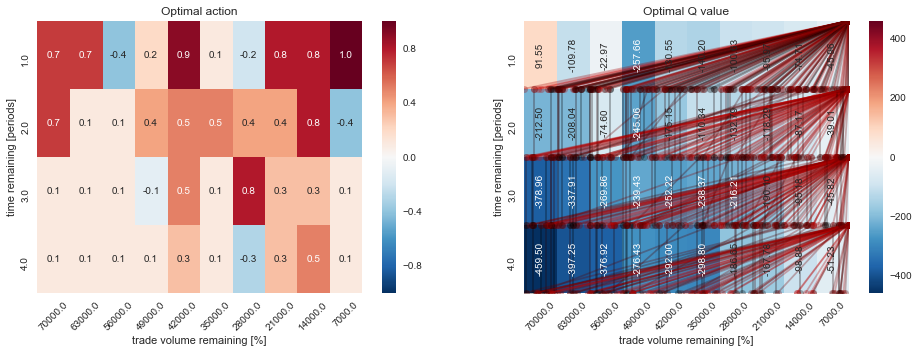

In [10]:
agent.heatmap_Q(show_traces=True)

In [ ]:
agent15.save(outfile='agent15.json', outfile_samples='agent15.csv')

Start parallel evalutions of strategies. (num_cores=24)


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    7.6s remaining:   43.3s
[Parallel(n_jobs=24)]: Done   8 out of  20 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=24)]: Done  13 out of  20 | elapsed:   10.5s remaining:    5.7s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:   13.2s remaining:    1.5s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:   17.3s finished


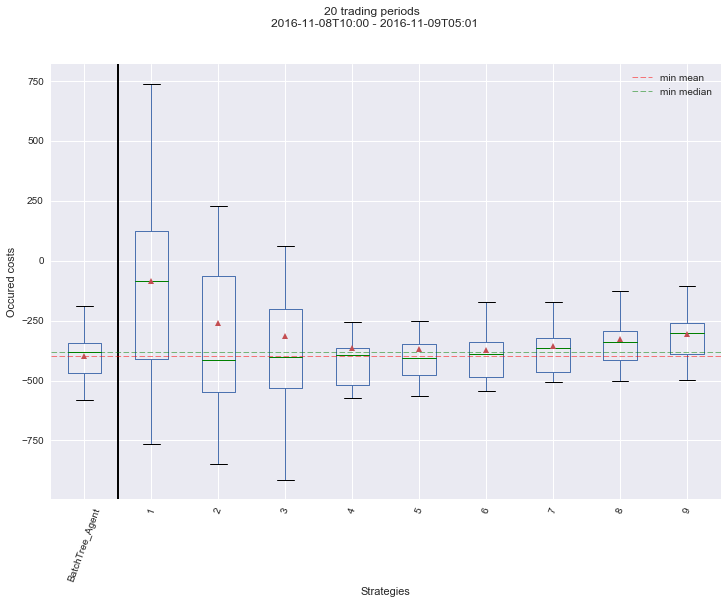

,BatchTree_Agent,1,2,3,4,5,6,7,8,9
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-396.329393,-85.297801,-260.467792,-315.683279,-363.234907,-369.858969,-373.524334,-356.220368,-328.066204,-304.591463
std,164.300626,464.797631,438.401164,389.042970,343.816241,295.850419,241.321635,214.006734,182.562907,168.306331
min,-782.207690,-764.012374,-847.915997,-913.080471,-901.858014,-885.576695,-797.701693,-762.672520,-642.949219,-626.685960
25%,-469.270469,-409.049293,-546.541843,-531.242872,-518.123757,-476.083783,-486.804137,-463.582583,-415.955745,-388.040247
50%,-381.002267,-86.440801,-414.402158,-402.169899,-391.911993,-405.042913,-388.968061,-364.353597,-340.388873,-301.663215
75%,-342.556818,122.935053,-64.950706,-200.137714,-363.005432,-346.535131,-338.182773,-324.402681,-295.285284,-260.895501
max,37.312598,1172.718924,1172.627409,1035.646605,916.121225,719.040014,487.631406,375.922718,254.810685,179.860334
rel_mean,1.000000,0.215219,0.657200,0.796517,0.916498,0.933211,0.942459,0.898799,0.827761,0.768531
rel_median,1.000000,0.226877,1.087663,1.055558,1.028634,1.063098,1.020907,0.956303,0.893404,0.791762


,BatchTree_Agent,1,2,3,4,5,6,7,8,9
2016-11-08T10:00,-579.856614,-589.250301,-606.708700,-565.805469,-548.208559,-524.194651,-517.704641,-506.441738,-420.397531,-399.469078
2016-11-08T11:01,-499.557001,130.520928,-484.450509,-526.980118,-517.568048,-515.660768,-510.791176,-490.030322,-480.039998,-460.342232
2016-11-08T12:01,-471.360777,20.790014,-540.881639,-523.628202,-519.790882,-445.285875,-436.218712,-398.484992,-381.430969,-366.176845
2016-11-08T13:01,-369.874221,101.049756,-94.900620,-125.771138,-388.217170,-419.245741,-448.138566,-417.543710,-400.281312,-360.553674
2016-11-08T14:01,-187.966791,153.477108,79.023593,61.532480,-12.485527,-115.023814,-171.530867,-207.514685,-211.560811,-172.242634
2016-11-08T15:01,-253.117095,269.914501,228.958513,-120.153687,-256.167685,-249.772952,-242.031569,-171.405823,-157.810152,-135.415144
2016-11-08T16:01,-320.752683,-468.848322,-385.958439,-363.692518,-345.064643,-334.394859,-318.524938,-294.506728,-126.018601,-106.533639
2016-11-08T17:01,-383.860478,-101.240456,-112.516743,-229.116281,-383.838540,-346.168944,-330.713036,-328.189126,-309.862042,-251.413738
2016-11-08T18:01,-349.824864,-71.641146,-72.793584,-224.926572,-377.910658,-346.657194,-340.672686,-331.259359,-306.788700,-281.103802
2016-11-08T19:01,-378.144056,120.406427,-41.422073,-394.598588,-368.985695,-358.196955,-349.520241,-313.043348,-285.127758,-264.056089


BatchTree_Agent   -396.329393
1                  -85.297801
2                 -260.467792
3                 -315.683279
4                 -363.234907
5                 -369.858969
6                 -373.524334
7                 -356.220368
8                 -328.066204
9                 -304.591463
dtype: float64

In [31]:
costs = None
costs = agent.evaluate(
    testdata=data[:20],
    additional_agents={
       # 'agent_noRand': agent_noRand,
       # 'agent_agg': agent_agg,
       # 'agent_agg_noRand': agent_agg_noRand,
       # 'agent_agg_noRand_fake': agent_agg_noRand,
       # 'agent_aggFut15': agent_aggFut15, 
       # 'agent_aggFut15_noRand': agent_aggFut15_noRand,
       # 'agent_aggFut15disc_noRand': agent_aggFut15disc_noRand,
       # 'agent_agg100': agent_agg100,
       # 'agent_Fut15_noRand': agent_Fut15_noRand,
       # 'agent_Fut15': agent_Fut15,
    },
    evaluate_actions=[1,2,3,4, 5, 6,7,8,9],
    costs=costs,
    verbose=False,
    show_plot=True)
display(costs)
display(costs.mean())

Start parallel evalutions of strategies. (num_cores=24)


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    3.3s remaining:   18.9s
[Parallel(n_jobs=24)]: Done   8 out of  20 | elapsed:    4.4s remaining:    6.5s
[Parallel(n_jobs=24)]: Done  13 out of  20 | elapsed:    5.3s remaining:    2.9s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:    6.2s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:    6.5s finished


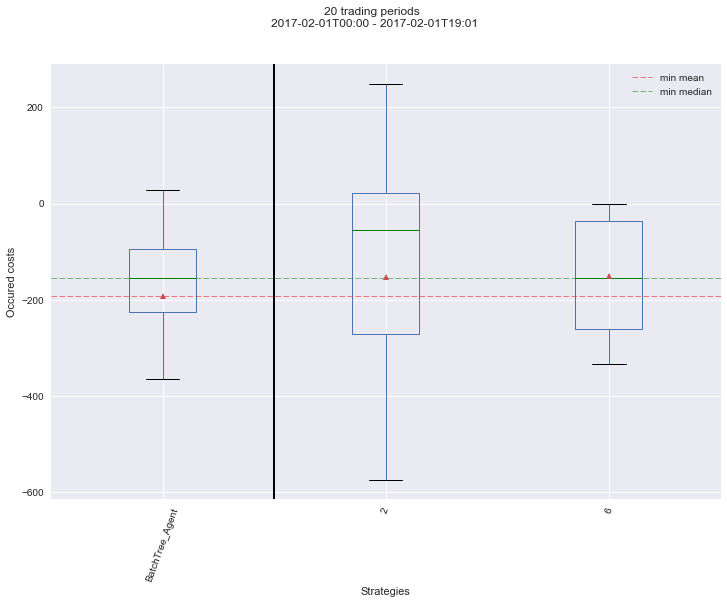

,BatchTree_Agent,2,6
count,20.000000,20.000000,20.000000
mean,-191.546180,-151.955321,-149.547773
std,174.288936,277.293440,116.436838
min,-629.062617,-773.588111,-333.328762
25%,-225.389688,-270.508641,-260.184943
50%,-154.472374,-54.244725,-153.801504
75%,-94.987039,22.194543,-37.067614
max,28.228168,247.933014,0.000000
rel_mean,1.000000,0.793309,0.780740
rel_median,1.000000,0.351161,0.995657


BatchTree_Agent   -191.546180
2                 -151.955321
6                 -149.547773
dtype: float64

In [35]:
costs = None
costs = agent.evaluate(
    testdata=data_feb[:20],
    additional_agents={
       # 'agent_noRand': agent_noRand,
       # 'agent_agg': agent_agg,
       # 'agent_agg_noRand': agent_agg_noRand,
       # 'agent_agg_noRand_fake': agent_agg_noRand,
       # 'agent_aggFut15': agent_aggFut15, 
       # 'agent_aggFut15_noRand': agent_aggFut15_noRand,
       # 'agent_aggFut15disc_noRand': agent_aggFut15disc_noRand,
       # 'agent_agg100': agent_agg100,
       # 'agent_Fut15_noRand': agent_Fut15_noRand,
       # 'agent_Fut15': agent_Fut15,
    },
    evaluate_actions=[2, 6],
    costs=costs,
    verbose=False,
    show_plot=True)
# display(costs)
display(costs.mean())